In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score


In [2]:
# Define the ERNIE model
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")
ernie_model = AutoModel.from_pretrained("nghuyong/ernie-2.0-en")

# Freeze ERNIE parameters
for param in ernie_model.parameters():
    param.requires_grad = False

D:\softwares__\anaconda\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
# Define the RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out

In [4]:
# Combine ERNIE and RNN
class ERNIE_RNN(nn.Module):
    def __init__(self, ernie_model, rnn_model):
        super(ERNIE_RNN, self).__init__()
        self.ernie = ernie_model
        self.rnn = rnn_model
    
    def forward(self, input_ids, attention_mask):
        ernie_output = self.ernie(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        rnn_output = self.rnn(ernie_output.last_hidden_state)
        return rnn_output, ernie_output.attentions  # Return attentions

In [5]:
# Define dataset and dataloader
class CommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(comment, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def preprocess_text(comment):
    # Convert to lowercase
    comment = comment.lower()
    comment = comment.encode('ascii', 'ignore').decode('ascii')
    # Remove URLs
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)  
    # Remove punctuation
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # Remove mentions (@username)
    comment = re.sub(r'@[^\s]+', '', comment)
    # Remove numbers
    comment = re.sub(r'\d+', '', comment)
    
    return comment

In [7]:
# Load data from CSV
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path, encoding='windows-1252')
    comments = df['Text'].tolist()
    labels = df['Label'].tolist()
    return comments, labels

In [8]:
# Define model, criterion, and optimizer
hidden_size = 128
num_classes = 2
rnn_model = RNNClassifier(ernie_model.config.hidden_size, hidden_size, num_classes)
model = ERNIE_RNN(ernie_model, rnn_model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Define function to calculate attention weights visualization
def visualize_attention(text, attention_weights):
    attentions = attention_weights[0]  # Extract the attention weights
    attention_weights = attentions[0][0]  # Get attention weights for the first layer and first head
    tokens = tokenizer.tokenize(text)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights[:len(tokens), :len(tokens)].detach().numpy(), cmap="YlGnBu", xticklabels=tokens, yticklabels=tokens, annot=True, fmt=".2f")
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.title('Attention Visualization')
    plt.show()

In [10]:
file_path = 'D:/Hindi_train_edit.csv'  # Update with your file path
comments, labels = load_data_from_csv(file_path)

comments = [preprocess_text(text) for text in comments]

# Tokenize and encode the comments
max_length = 128  # Update as needed
dataset = CommentDataset(comments, labels, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [11]:
# Training loop
num_epochs = 15

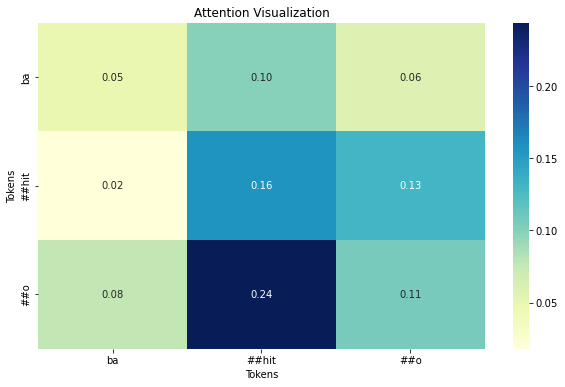

Epoch [1/15], Loss: 0.4534, Accuracy: 0.7680, F1 Score: 0.7752, Precision: 0.7519


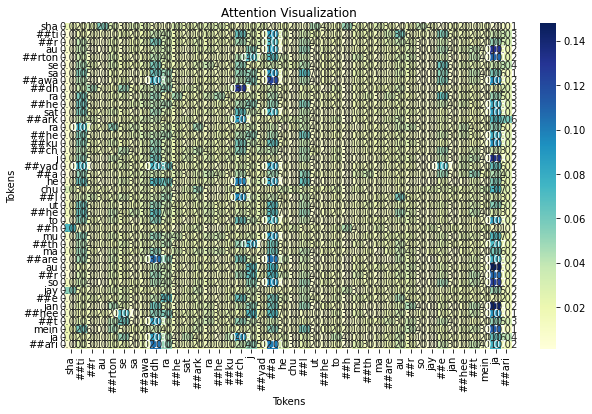

Epoch [2/15], Loss: 0.4243, Accuracy: 0.7860, F1 Score: 0.7918, Precision: 0.7708


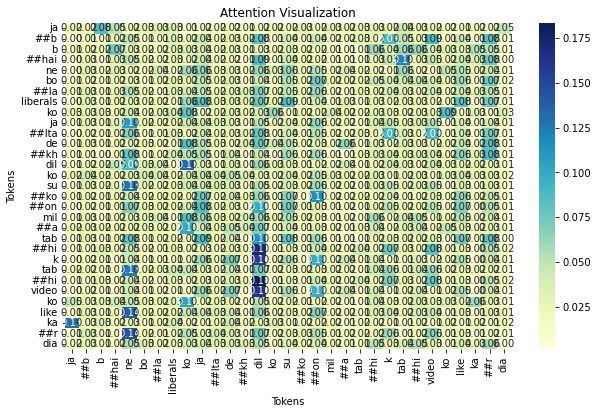

Epoch [3/15], Loss: 0.4174, Accuracy: 0.8030, F1 Score: 0.8108, Precision: 0.7800


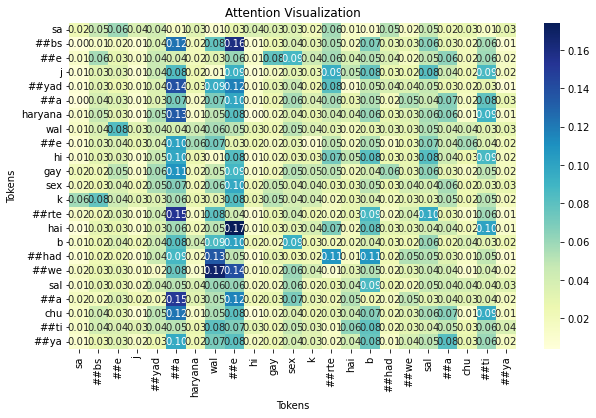

Epoch [4/15], Loss: 0.3905, Accuracy: 0.8180, F1 Score: 0.8230, Precision: 0.8011


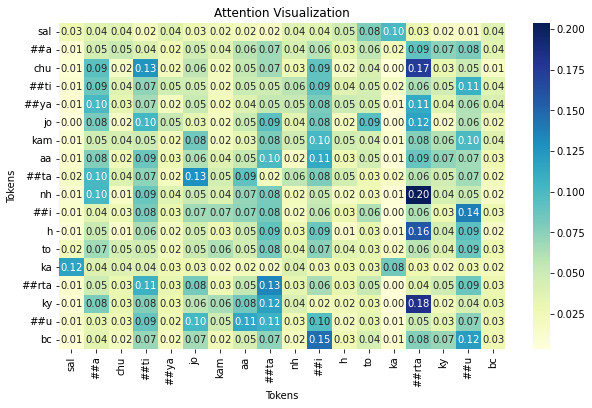

Epoch [5/15], Loss: 0.4234, Accuracy: 0.7890, F1 Score: 0.7981, Precision: 0.7651


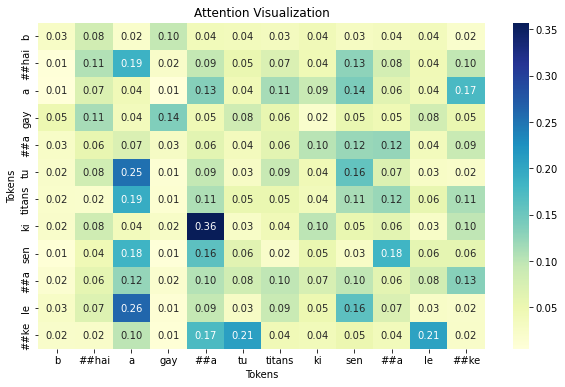

Epoch [6/15], Loss: 0.3781, Accuracy: 0.8160, F1 Score: 0.8182, Precision: 0.8086


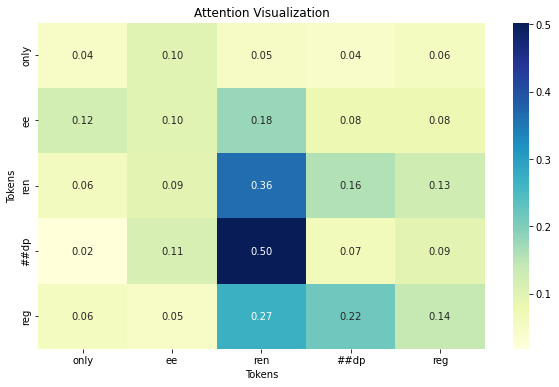

Epoch [7/15], Loss: 0.3791, Accuracy: 0.8210, F1 Score: 0.8257, Precision: 0.8046


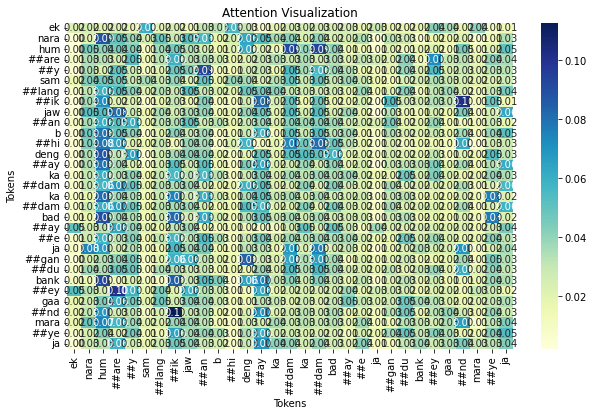

Epoch [8/15], Loss: 0.3639, Accuracy: 0.8300, F1 Score: 0.8343, Precision: 0.8137


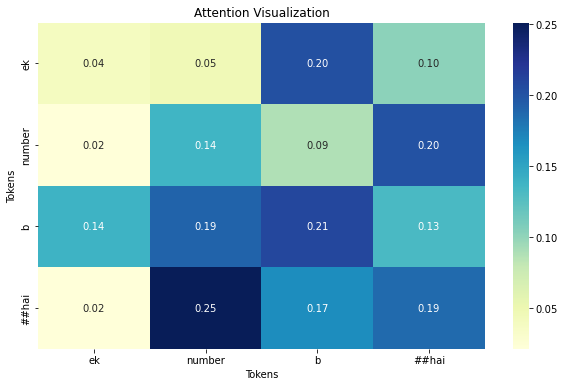

Epoch [9/15], Loss: 0.3478, Accuracy: 0.8350, F1 Score: 0.8384, Precision: 0.8215


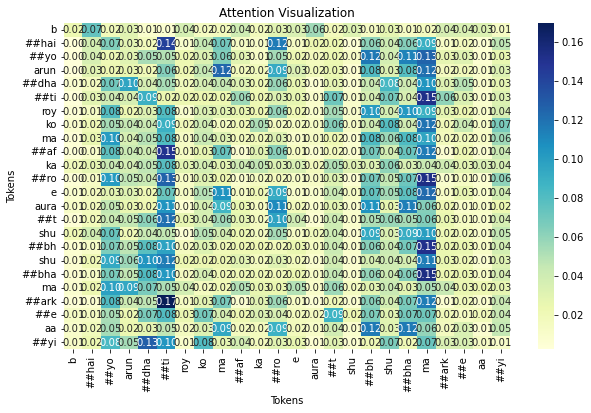

Epoch [10/15], Loss: 0.3312, Accuracy: 0.8420, F1 Score: 0.8463, Precision: 0.8239


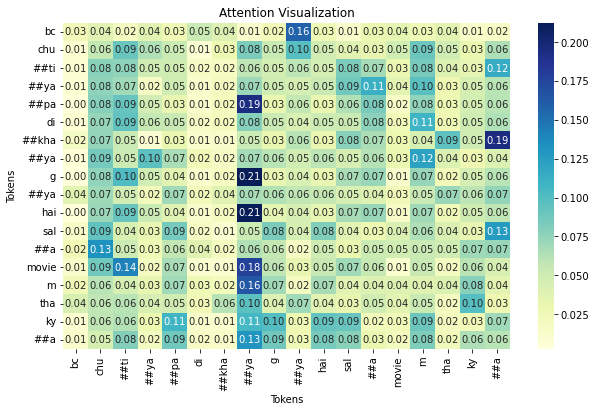

Epoch [11/15], Loss: 0.3175, Accuracy: 0.8480, F1 Score: 0.8513, Precision: 0.8333


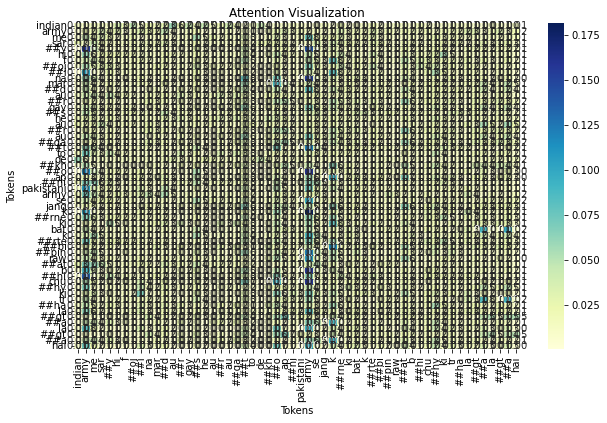

Epoch [12/15], Loss: 0.3538, Accuracy: 0.8340, F1 Score: 0.8373, Precision: 0.8212


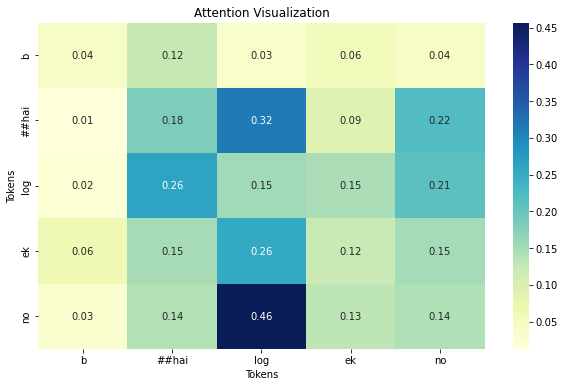

Epoch [13/15], Loss: 0.3068, Accuracy: 0.8400, F1 Score: 0.8444, Precision: 0.8220


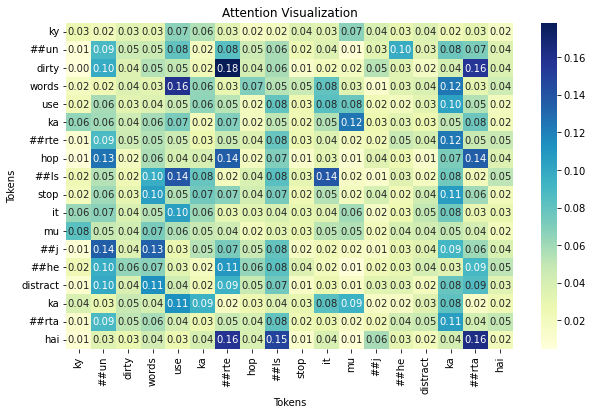

Epoch [14/15], Loss: 0.2637, Accuracy: 0.8720, F1 Score: 0.8740, Precision: 0.8605


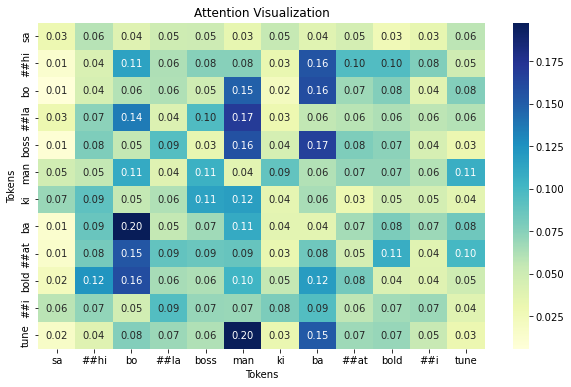

Epoch [15/15], Loss: 0.2693, Accuracy: 0.8660, F1 Score: 0.8694, Precision: 0.8479


In [13]:
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    predictions = []
    true_labels = []
    
    # Visualize attention for a sample comment at the beginning of each epoch
    for i, batch in enumerate(dataloader):
        if i == 0:  # Visualize attention for the first sample of the first batch in each epoch
            inputs = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass
            outputs, attentions = model(input_ids=inputs, attention_mask=attention_mask)
            
            # Decode the input_ids to get the sample text
            sample_text = tokenizer.decode(inputs[0], skip_special_tokens=True)
            
            # Visualize attention for the sample text
            visualize_attention(sample_text, attentions)

    for i, batch in enumerate(dataloader):  
        optimizer.zero_grad()
        inputs = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs, attentions = model(input_ids=inputs, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = (predicted_labels == labels).sum().item() / len(labels)
        total_accuracy += accuracy
        
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = total_accuracy / len(dataloader)
    
    # Calculate additional metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}')


In [14]:
import torch
torch.save(model.state_dict(), 'ernie_rnn_model_hindi.pth')

In [11]:
# Load the saved model weights
model.load_state_dict(torch.load('ernie_rnn_model_hindi.pth'))
model.eval()

# Define tokenizer and max_length
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")
max_length = 128


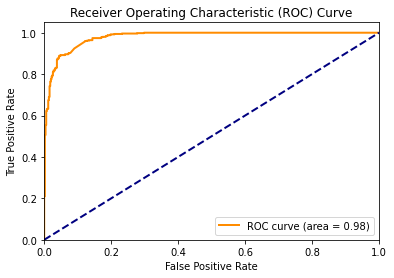

In [12]:
from sklearn.metrics import roc_curve, auc

# Collect predictions and true labels
all_predictions = []
all_true_labels = []

# Collect predictions and true labels
for batch in dataloader:
    inputs = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    
    outputs, _ = model(input_ids=inputs, attention_mask=attention_mask)
    probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities for positive class
    all_predictions.extend(probabilities.detach().cpu().numpy())
    all_true_labels.extend(labels.cpu().numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_true_labels, all_predictions)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
def predict_text(text, model, tokenizer, device):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)
    
    # Tokenize and encode the text
    encoded_input = tokenizer(preprocessed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    
    # Forward pass through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Get predicted label
    predicted_label = torch.argmax(outputs, dim=1).item()
    
    return predicted_label

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
user_input = input("Enter your text: ")
predicted_label = predict_text(user_input, model, tokenizer, device)

if predicted_label == 1:
    print('This text contains cyberbullying content')
else:
    print('This text does not contain cyberbullying content')

Enter your text: chal ghumne chalte hain
This text does not contain cyberbullying content
